In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import re
import sys
import os
import mne
import mne_connectivity
import IPython
import seaborn as sns
import scipy
import joblib
import h5io
import dask.array as da 
import itertools
from plotnine import *

import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest
import tensorpac as tp

In [3]:
## Prep paths ##

subject = 'BJH027'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [4]:
## Load Neural Data

# load
last_away_epochs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_filtered_clean_last_away_events.fif")

# get good epochs (for behavioral data only)
good_epochs = [i for i,x in enumerate(last_away_epochs.get_annotations_per_epoch()) if not x]
bad_epochs = [i for i,x in enumerate(last_away_epochs.get_annotations_per_epoch()) if  x]

# load behavioral data
last_away_data = pd.read_csv(f"{raw_data_dir}/behave/{subject}_last_away_events.csv")

# set info as metadata
last_away_epochs.metadata = last_away_data

# onlt good epochs
last_away_epochs = last_away_epochs[good_epochs]

Reading /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_bp_filtered_clean_last_away_events.fif ...


/tmp/ipykernel_1981949/1489456339.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_bp_filtered_clean_last_away_events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz


    Found the data of interest:
        t =   -5000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Reading /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_bp_filtered_clean_last_away_events-1.fif ...
    Found the data of interest:
        t =   -5000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
207 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 5 columns


In [5]:
example_channel = last_away_epochs.pick(['AL10-AL11'])

In [6]:
example_channel = example_channel.resample(512)

In [7]:
example_data = example_channel.get_data()

In [8]:
example_data = np.squeeze(example_data)
example_data.shape

(140, 5120)

In [109]:
# Define a Pac object
p = tp.Pac(idpac=(6, 0, 0), f_pha='hres', f_amp='hres')
# Filter the data and extract pac
xpac = p.filterfit(example_channel.info['sfreq'], example_data)

Phase Amplitude Coupling object defined
    extract phases (n_pha=50) and amplitudes (n_amps=50)
    true PAC estimation using Gaussian Copula PAC (gcPac)


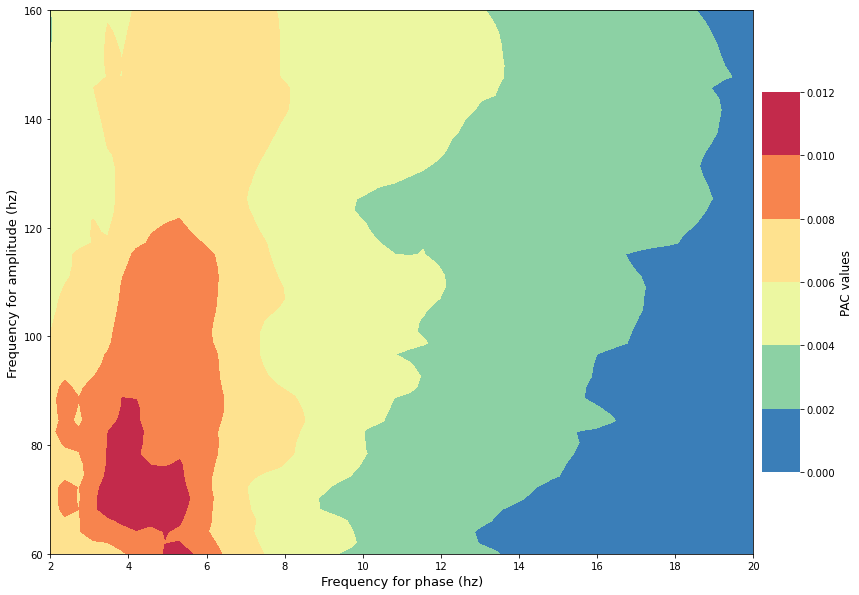

In [110]:
# plot your Phase-Amplitude Coupling :
p.comodulogram(xpac.mean(-1), cmap='Spectral_r', plotas='contour', ncontours=5,
               title='',
               fz_title=14, fz_labels=13)

p.show()

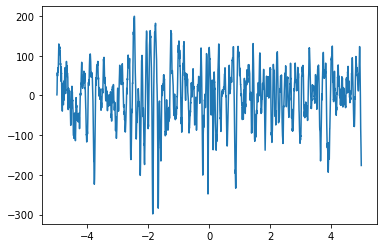

In [10]:
plt.rcParams['figure.figsize'] = [45, 10]


plt.plot(example_channel.times, example_data[0,:])

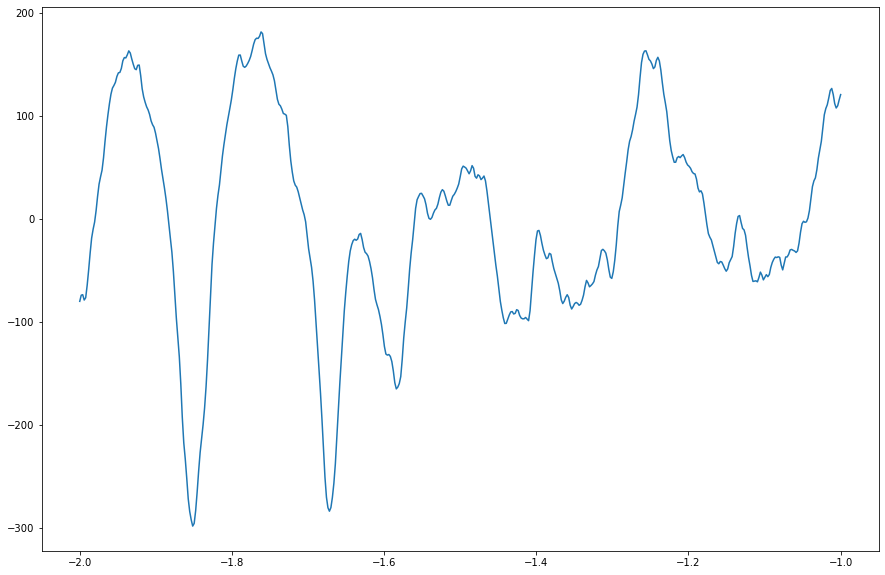

In [11]:
plt.rcParams['figure.figsize'] = [15, 10]

time_index = np.where((example_channel.times <= -1) & (example_channel.times >= -2))
time_series = np.squeeze(example_data[0,time_index])

plt.plot(example_channel.times[time_index],time_series)

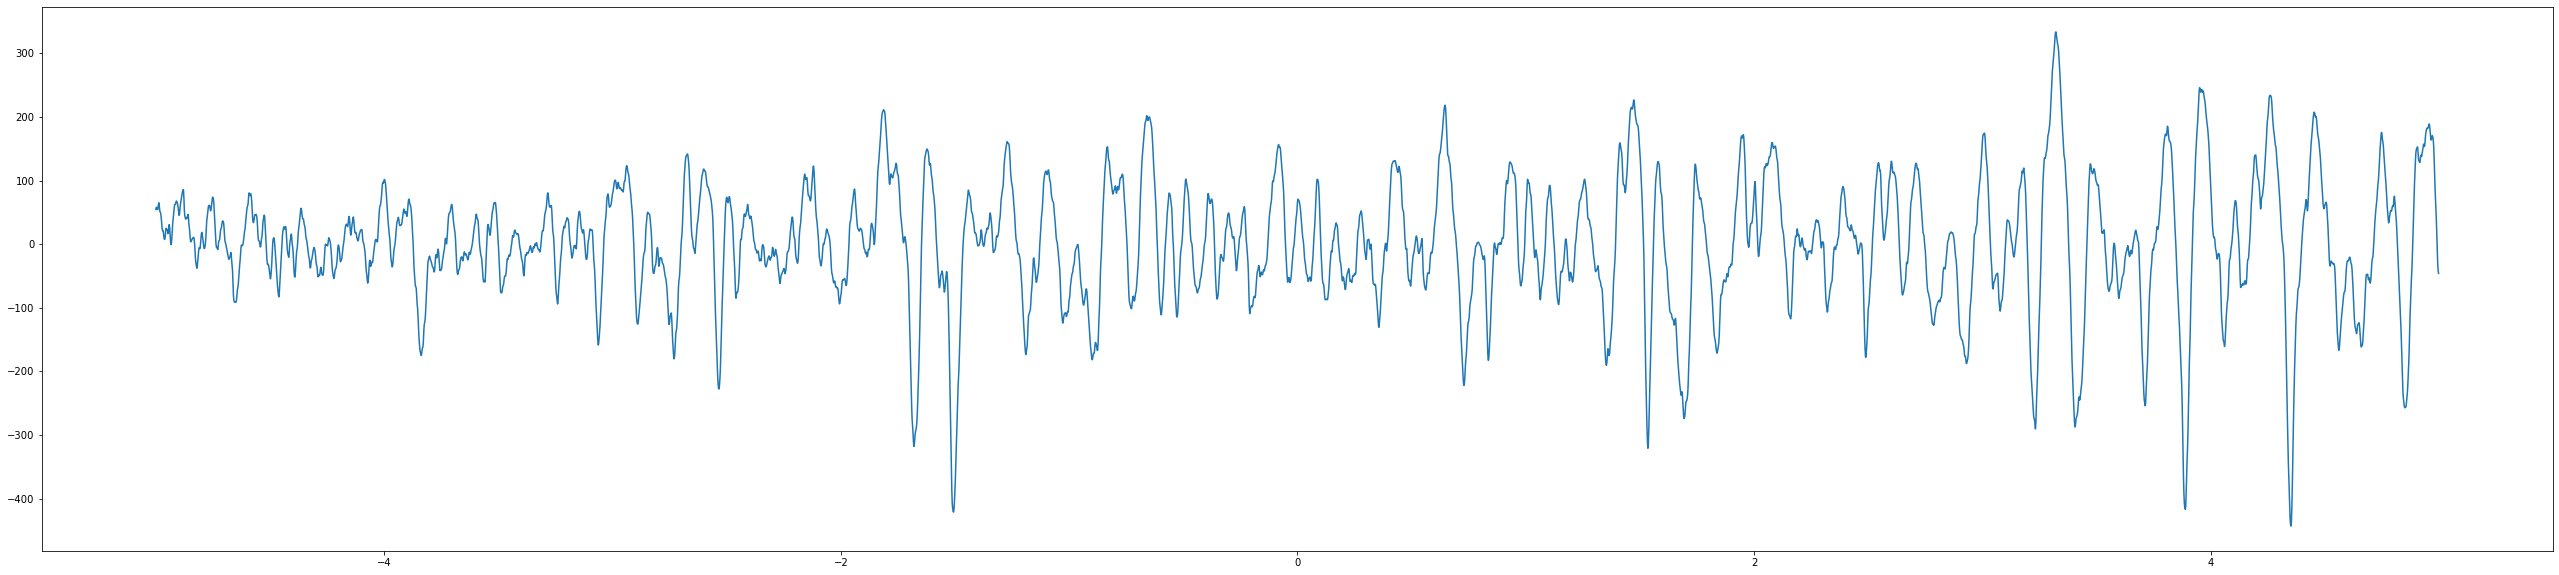

In [12]:
plt.rcParams['figure.figsize'] = [45, 10]


plt.plot(example_channel.times, example_data[99,:])

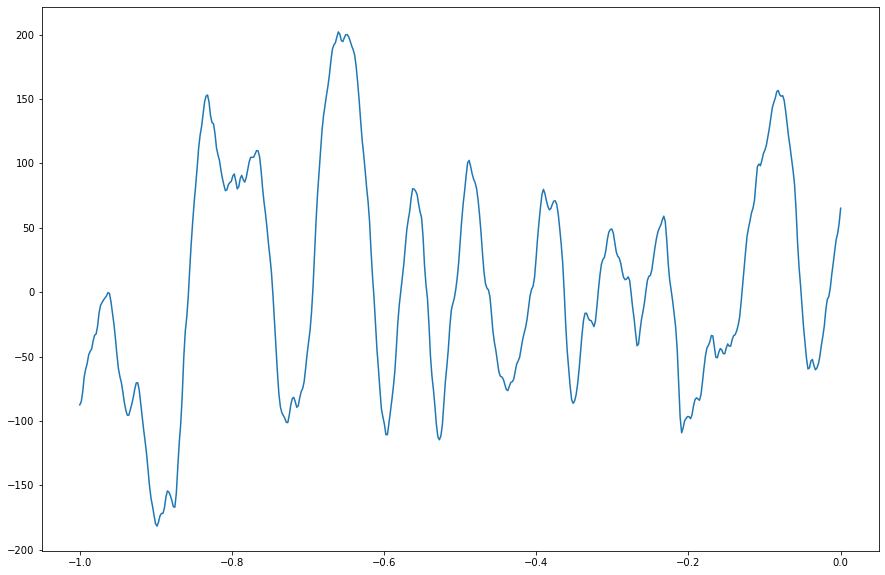

In [13]:
plt.rcParams['figure.figsize'] = [15, 10]

time_index = np.where((example_channel.times <= 0) & (example_channel.times >= -1))
time_series = np.squeeze(example_data[99,time_index])

plt.plot(example_channel.times[time_index],time_series)

In [71]:
itc = tp.utils.ITC(example_data, example_channel.info['sfreq'], f_pha=(2, 20, 1, .2))


Inter-Trials Coherence (ITC)
    extracting 85 phases


<Axes: title={'center': 'Inter-Trials Coherence (140 trials)'}, xlabel='Time', ylabel='Frequency for phase (Hz)'>

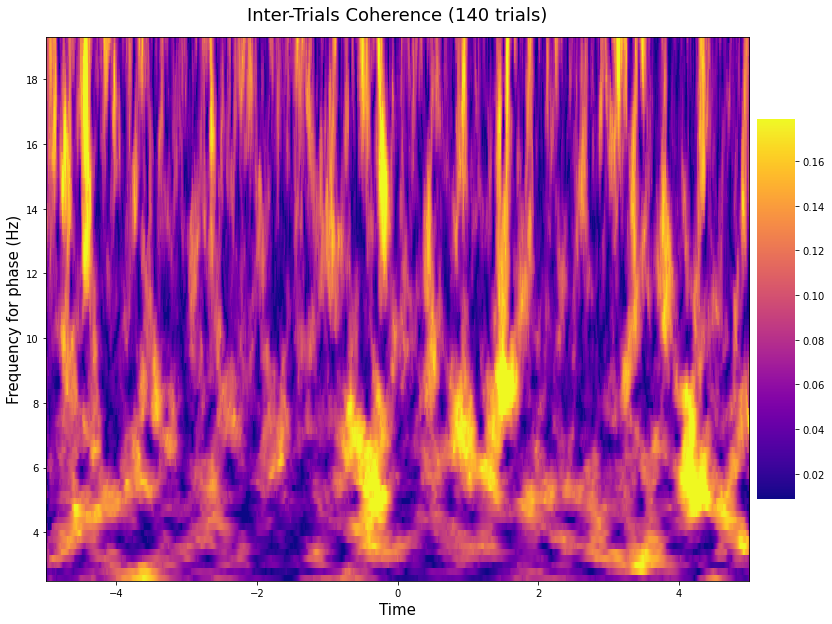

In [72]:
itc.plot(times=example_channel.times, cmap='plasma', fz_labels=15, fz_title=18)

In [73]:
psd = tp.utils.PSD(example_data, example_channel.info['sfreq'])


Compute PSD over 140 trials and 5120 time points


    Add 95th confidence interval
/tmp/ipykernel_1977998/2617122386.py:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)


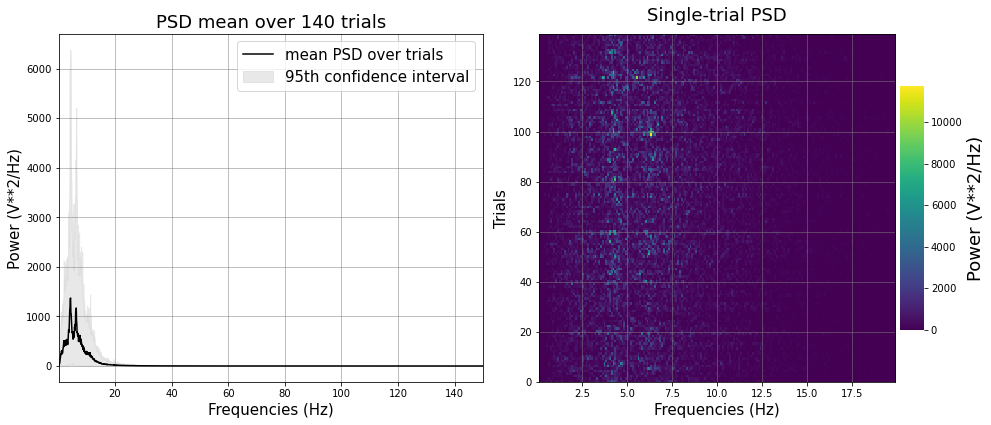

In [85]:
plt.figure(figsize=(14, 6))
# adding the mean PSD over trials
plt.subplot(1, 2, 1)
ax = psd.plot(confidence=95, f_min=0.1, f_max=150, grid=True)
# plt.axvline(8, lw=2, color='red')
# plt.axvline(12, lw=2, color='red')
# adding the single trial PSD
plt.subplot(1, 2, 2)
psd.plot_st_psd( f_min=.1, f_max=20, 
                grid=True)
# plt.axvline(8, lw=2, color='red')
# plt.axvline(12, lw=2, color='red')
plt.tight_layout()
plt.show()

    Add 95th confidence interval
/tmp/ipykernel_1977998/967805332.py:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)


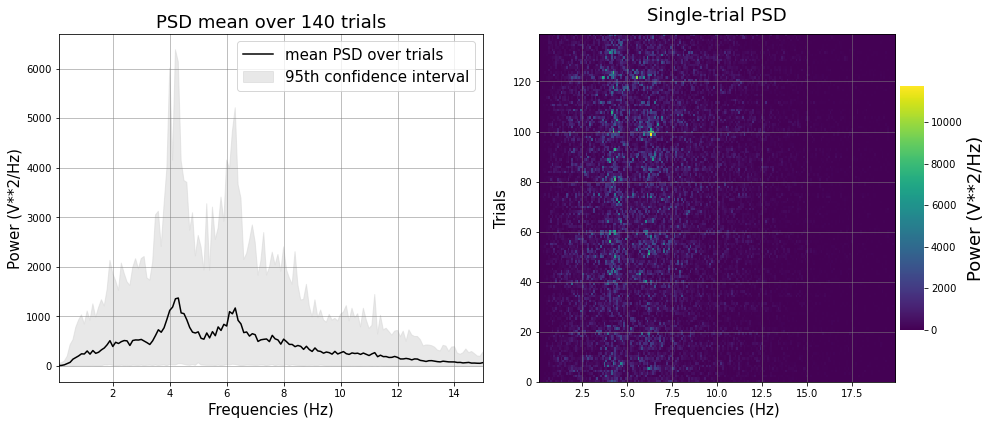

In [165]:
plt.figure(figsize=(14, 6))
# adding the mean PSD over trials
plt.subplot(1, 2, 1)
ax = psd.plot(confidence=95, f_min=0.1, f_max=15, grid=True)
# plt.axvline(8, lw=2, color='red')
# plt.axvline(12, lw=2, color='red')
# adding the single trial PSD
plt.subplot(1, 2, 2)
psd.plot_st_psd( f_min=.1, f_max=20, 
                grid=True)
# plt.axvline(8, lw=2, color='red')
# plt.axvline(12, lw=2, color='red')
plt.tight_layout()
plt.show()

In [9]:
rp_obj =tp.EventRelatedPac(f_pha=[3, 8], f_amp=(30, 160, 30, 2))
erpac = rp_obj.filterfit(example_channel.info['sfreq'], example_data, method='gc', smooth=100)


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=50)
    Compute Gaussian-Copula ERPAC


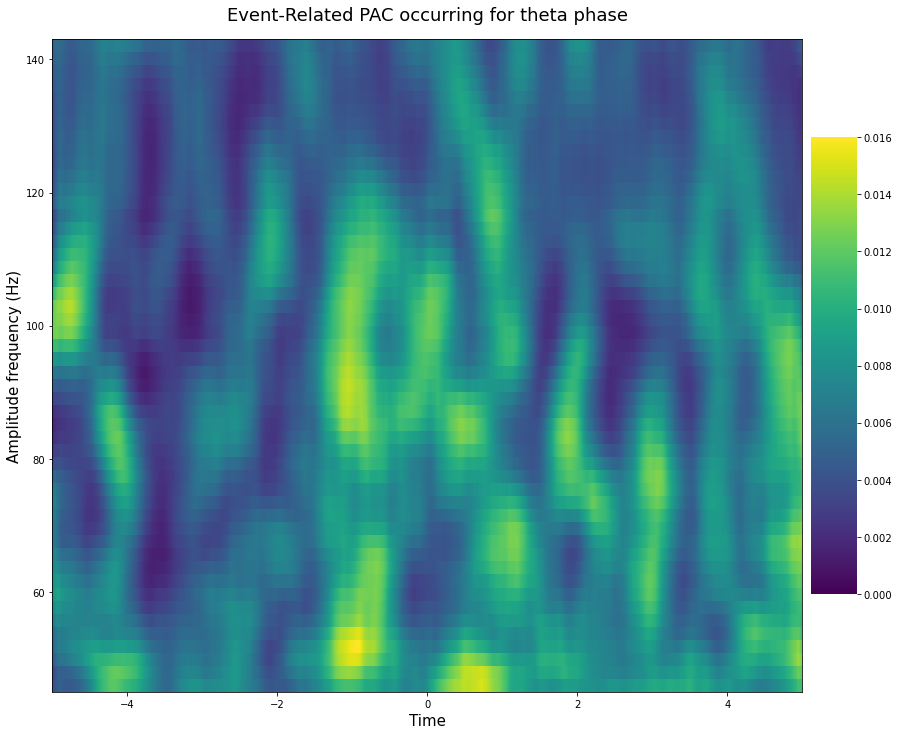

In [10]:
plt.figure(figsize=(16, 12))
rp_obj.pacplot(erpac.squeeze(), example_channel.times, rp_obj.yvec, xlabel='Time',
               ylabel='Amplitude frequency (Hz)',
               title='Event-Related PAC occurring for theta phase',
               fz_labels=15, fz_title=18)
plt.show()

In [98]:
example_data.shape

(140, 5120)

In [172]:
peak = tp.utils.PeakLockedTF(example_data, example_channel.info['sfreq'], 0., times=example_channel.times, f_pha=[3, 6],
                    f_amp= 'hres')

PeakLockedTF object defined
    align on time-point=0.0 (sample=2559)
    extract phase and amplitudes (n_amps=50)
    running peak detection around sample=2559
    realign the 140 phases and amplitudes


In [218]:
peak

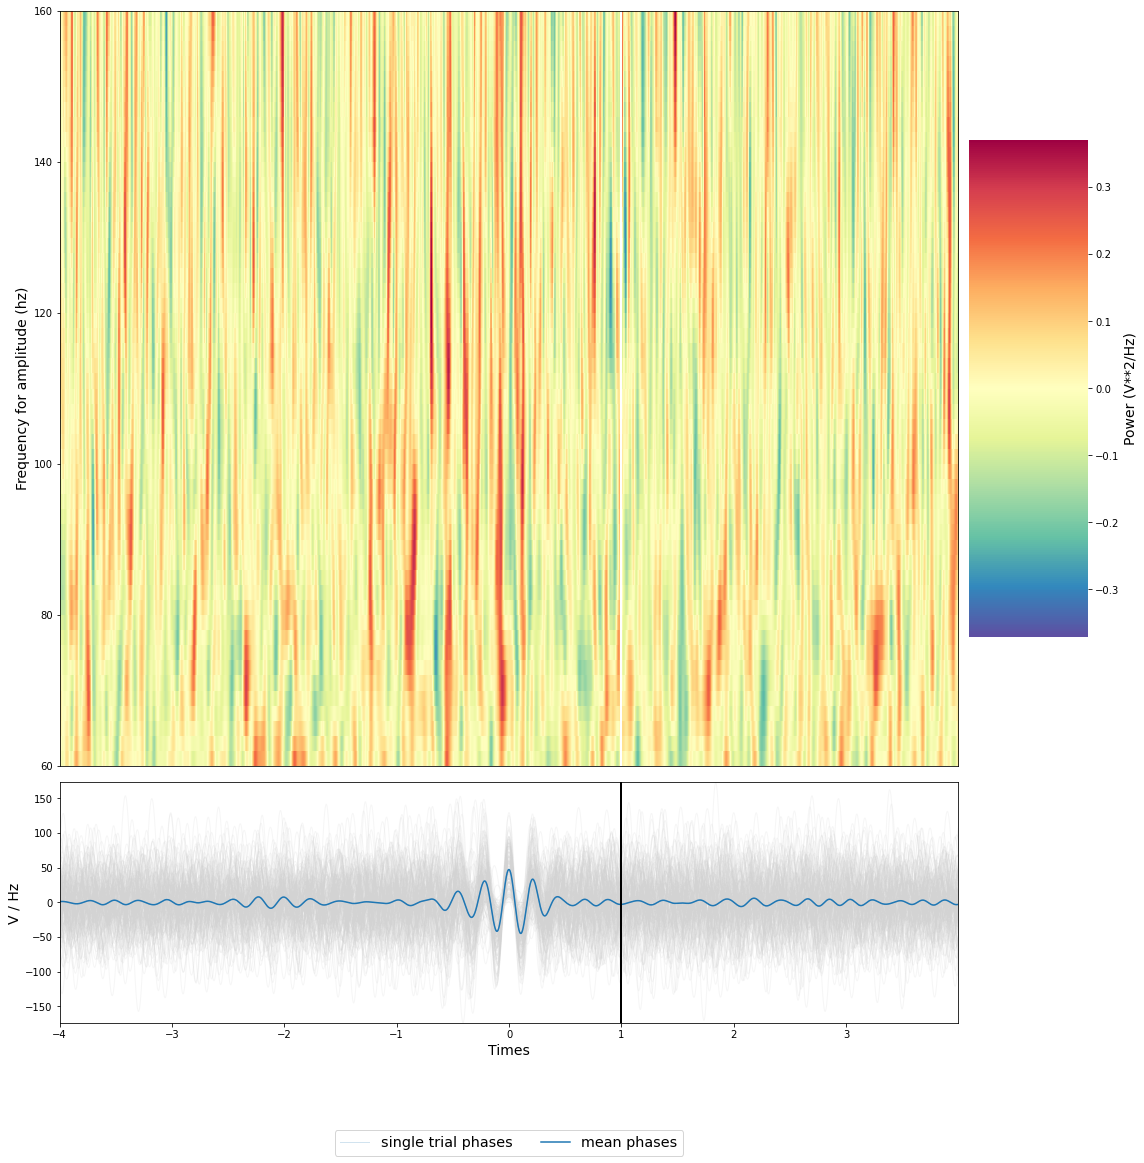

In [216]:
plt.figure(figsize=(16, 16))
ax_1, ax_2 = peak.plot(zscore=True, edges = 512, cmap='Spectral_r')
plt.tight_layout()
plt.show()

In [158]:
# define phase and amplitude filtering properties
kw_filt = dict(f_pha=[3, 6], f_amp=[60, 90], n_bins=20)
# bin the rest, planning and execution periods. Note that ideally, the entire
# trial should be filtered and then binning should be performed
bin_data = tp.utils.BinAmplitude(example_data, example_channel.info['sfreq'], **kw_filt)

Binning [60, 90]Hz amplitude according to [3, 6]Hz phase


((0.7, 1.1), Text(0.5, 1.0, ''))

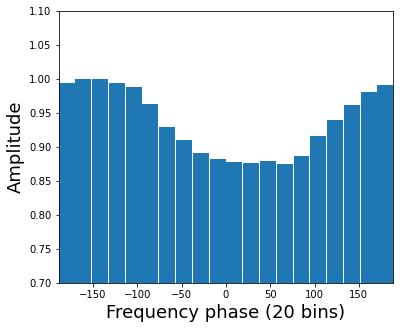

In [159]:
plt.figure(figsize=(6, 5))
bin_data.plot(normalize=True,  unit='deg')
plt.ylim(0.7, 1.1), plt.title("", fontsize=18)


In [175]:
pp_obj = tp.PreferredPhase(f_pha=[3, 6])
# only extract the alpha phase
pp_pha = pp_obj.filter(example_channel.info['sfreq'], example_data, ftype='phase')
pp_amp = p.filter(example_channel.info['sfreq'], example_data, ftype='amplitude')
# compute the preferred phase (reuse the amplitude computed above)
ampbin, pp, vecbin = pp_obj.fit(pp_pha, pp_amp, n_bins=72)
# mean binned amplitude across trials
ampbin = np.squeeze(ampbin).mean(-1).T


Preferred phase object defined


(array([ 9., 11.,  8., 12., 12.,  9.,  5.,  3.,  6.,  3.,  2.,  1.,  1.,
         1.,  1.,  2.,  5.,  2.,  2.,  5.,  7.,  5.,  9.,  9., 10.]),
 array([-3.09795942, -2.85012267, -2.60228591, -2.35444916, -2.10661241,
        -1.85877565, -1.6109389 , -1.36310215, -1.11526539, -0.86742864,
        -0.61959188, -0.37175513, -0.12391838,  0.12391838,  0.37175513,
         0.61959188,  0.86742864,  1.11526539,  1.36310215,  1.6109389 ,
         1.85877565,  2.10661241,  2.35444916,  2.60228591,  2.85012267,
         3.09795942]),
 <BarContainer object of 25 artists>)

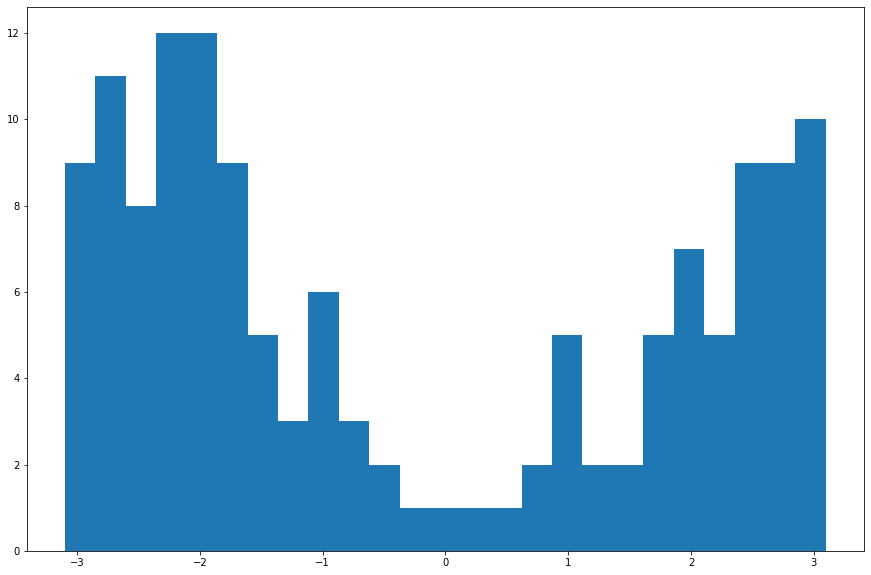

In [214]:
plt.hist(pp[14, 0, :], bins = 25)

In [178]:
pp_mean = np.squeeze(pp.mean(-1))

In [212]:
pp_mean[8:15]

array([-0.17889625, -0.23624278, -0.12528971, -0.09536978, -0.18949289,
       -0.33722254, -0.28860266])

<PolarAxes: >

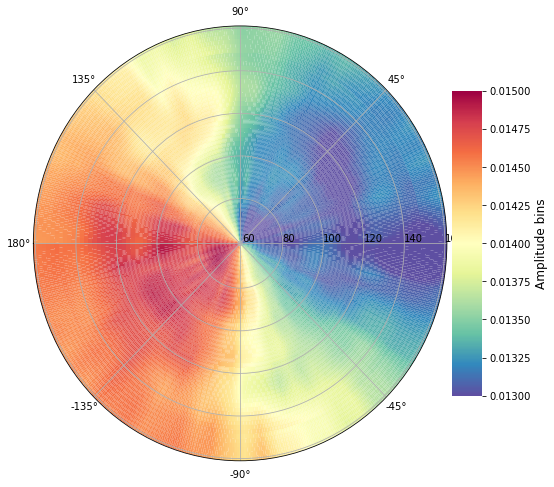

In [163]:
plt.figure(figsize=(30, 8))
kw_plt = dict(cmap='Spectral_r', interp=.1, cblabel='Amplitude bins',
              vmin=0.013, vmax=0.015, colorbar=True, y=1.05, fz_title=18)
pp_obj.polar(ampbin, vecbin, p.yvec, subplot=131, title='',
             **kw_plt)


In [206]:
vecbin[5]

-2.6991148150560194

In [198]:
len(p.yvec)


50

In [201]:
pp_mean[0] # preferred phase for an amplitude bin of 60Hz

-0.22626947088355384

In [204]:
np.where(ampbin[0] == np.max(ampbin[0]))

(array([5]),)

In [205]:
ampbin[0]

array([0.01473017, 0.01473831, 0.01478396, 0.01481305, 0.01478002,
       0.01484038, 0.01479048, 0.01478654, 0.01474649, 0.0147374 ,
       0.01469205, 0.01457967, 0.01456308, 0.01453002, 0.01452111,
       0.01437493, 0.01442783, 0.01423311, 0.01415069, 0.01422825,
       0.0140848 , 0.01407516, 0.01393593, 0.01391273, 0.0138369 ,
       0.01372992, 0.01368391, 0.01355169, 0.01356146, 0.01344557,
       0.0134956 , 0.01337561, 0.01336956, 0.01336233, 0.0132774 ,
       0.01318631, 0.01327065, 0.01313595, 0.01313351, 0.01303898,
       0.01302286, 0.01303774, 0.0130071 , 0.01296007, 0.01299066,
       0.01304368, 0.01302287, 0.013108  , 0.01301415, 0.01313419,
       0.01314122, 0.0132714 , 0.0132036 , 0.01326137, 0.01327953,
       0.01346842, 0.01366999, 0.01373539, 0.01379421, 0.01386499,
       0.01393517, 0.01406727, 0.01413238, 0.01429884, 0.01419493,
       0.01438037, 0.01448366, 0.01450522, 0.01455874, 0.01459952,
       0.01463011, 0.01467084])

In [164]:
df = tp.stats.test_stationarity(example_data, p=0.05)
print(df)

Performing a Augmented Dickey-Fuller test on 140 epochs with p=0.05
    140/140 epochs were found as significantly stationary at p=0.05


        Epochs      P-values  Stationary  Statistics   CV (5%)   CV (1%)
0      epoch 0  2.278893e-22        True  -12.076919 -2.862108 -3.431636
1      epoch 1  2.060501e-20        True  -11.216755 -2.862108 -3.431636
2      epoch 2  1.544266e-21        True  -11.704023 -2.862108 -3.431636
3      epoch 3  1.383626e-22        True  -12.176320 -2.862108 -3.431636
4      epoch 4  4.722395e-22        True  -11.933441 -2.862108 -3.431636
..         ...           ...         ...         ...       ...       ...
135  epoch 135  5.016452e-24        True  -12.865022 -2.862108 -3.431636
136  epoch 136  1.119341e-22        True  -12.218840 -2.862108 -3.431636
137  epoch 137  7.738520e-24        True  -12.771903 -2.862108 -3.431636
138  epoch 138  6.960188e-25        True  -13.303875 -2.862108 -3.431636
139  epoch 139  2.716546e-23        True  -12.507766 -2.862108 -3.431636

[140 rows x 6 columns]


# THETA

In [23]:
epochs_filtered = example_channel.copy().filter(l_freq=3, h_freq=150, fir_design='firwin')


Setting up band-pass filter from 3 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 37.50 Hz (-6 dB cutoff frequency: 168.75 Hz)
- Filter length: 845 samples (1.650 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s


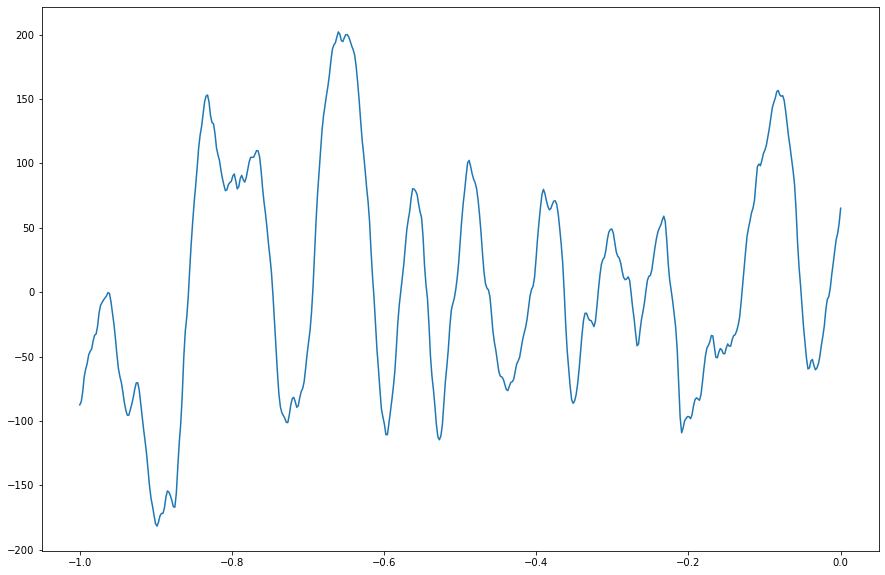

In [14]:
plt.rcParams['figure.figsize'] = [15, 10]

time_index = np.where((example_channel.times <= 0) & (example_channel.times >= -1))
time_series = np.squeeze(example_data[99,time_index])

plt.plot(example_channel.times[time_index],time_series)

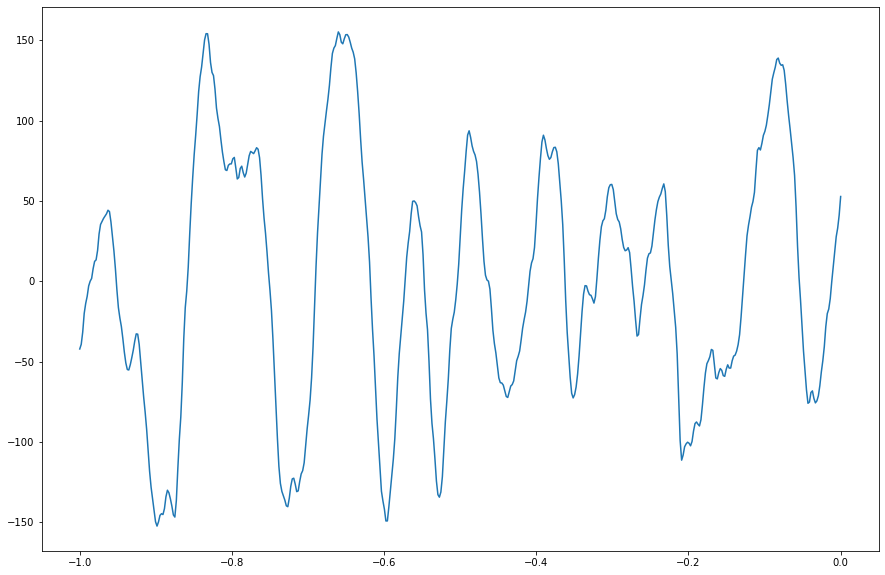

In [24]:
filtered_data = epochs_filtered.get_data()
time_index = np.where((epochs_filtered.times <= 0) & (epochs_filtered.times >= -1))
time_series = np.squeeze(filtered_data[99,:, time_index])

plt.plot(example_channel.times[time_index],time_series)

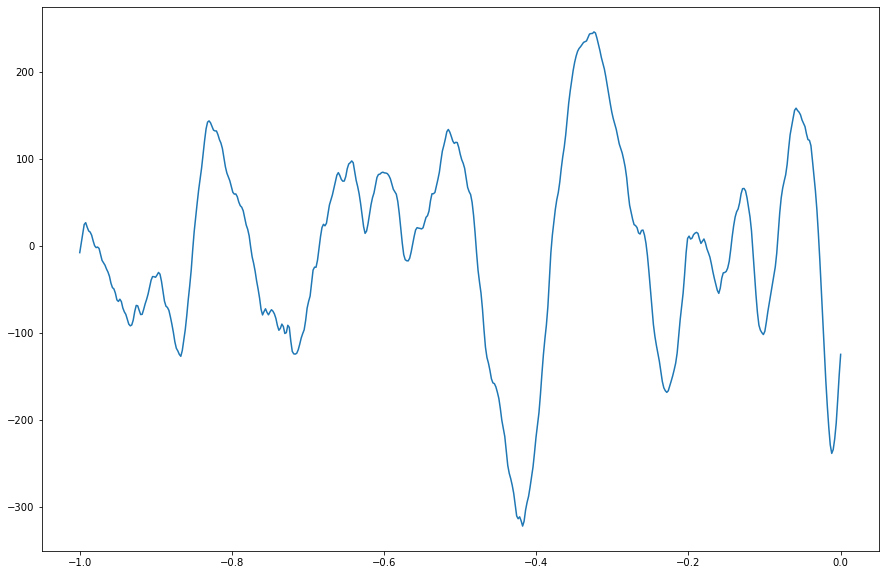

In [25]:
filtered_data = epochs_filtered.get_data()
time_index = np.where((epochs_filtered.times <= 0) & (epochs_filtered.times >= -1))
time_series = np.squeeze(filtered_data[103,:, time_index])

plt.plot(example_channel.times[time_index],time_series)

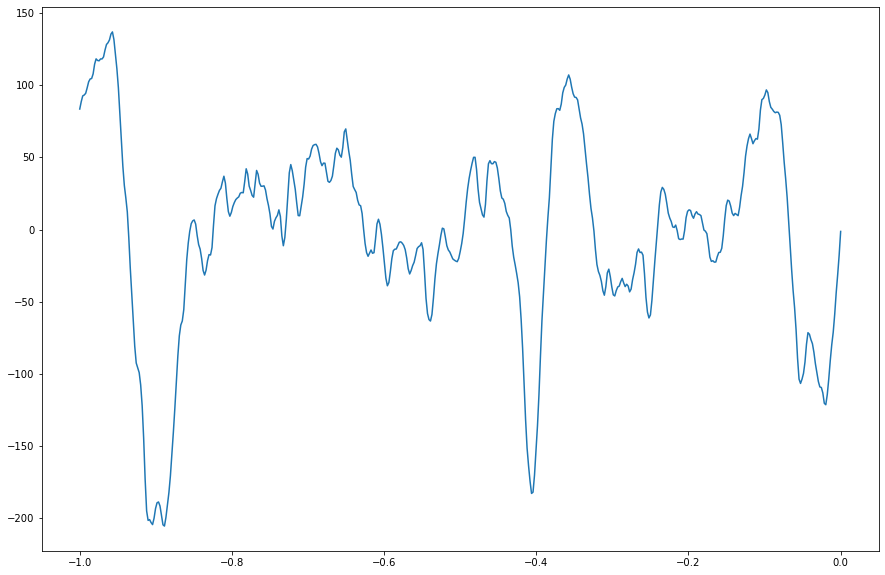

In [26]:
filtered_data = epochs_filtered.get_data()
time_index = np.where((epochs_filtered.times <= 0) & (epochs_filtered.times >= -1))
time_series = np.squeeze(filtered_data[42,:, time_index])

plt.plot(example_channel.times[time_index],time_series)

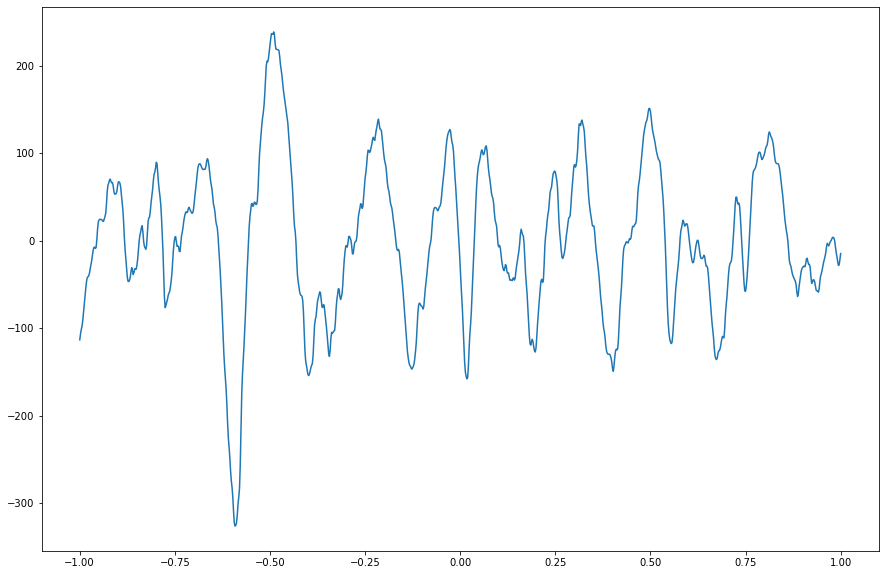

In [28]:
filtered_data = epochs_filtered.get_data()
time_index = np.where((epochs_filtered.times <= 1) & (epochs_filtered.times >= -1))
time_series = np.squeeze(filtered_data[88,:, time_index])

plt.plot(example_channel.times[time_index],time_series)

# ALPHA

In [29]:
epochs_filtered = example_channel.copy().filter(l_freq=9, h_freq=150, fir_design='firwin')


Setting up band-pass filter from 9 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 2.25 Hz (-6 dB cutoff frequency: 7.88 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 37.50 Hz (-6 dB cutoff frequency: 168.75 Hz)
- Filter length: 751 samples (1.467 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s


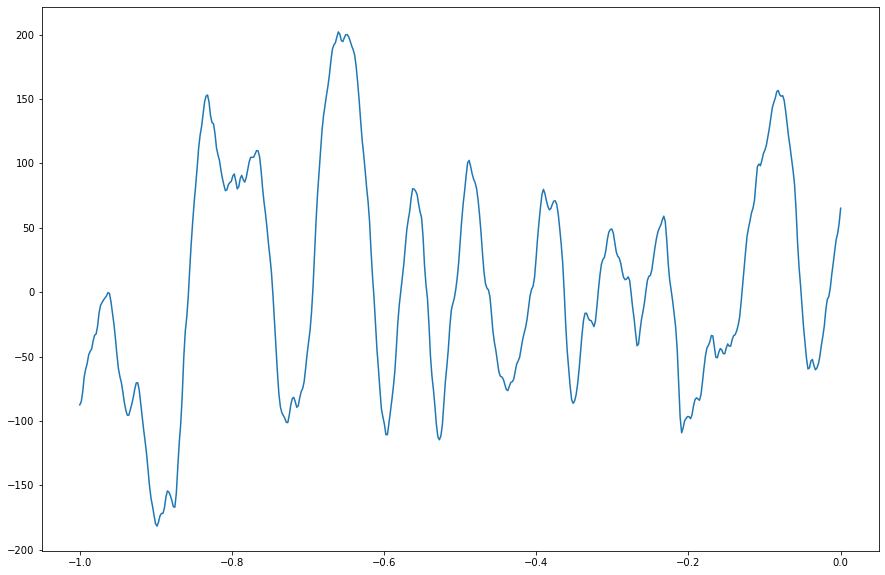

In [30]:
plt.rcParams['figure.figsize'] = [15, 10]

time_index = np.where((example_channel.times <= 0) & (example_channel.times >= -1))
time_series = np.squeeze(example_data[99,time_index])

plt.plot(example_channel.times[time_index],time_series)

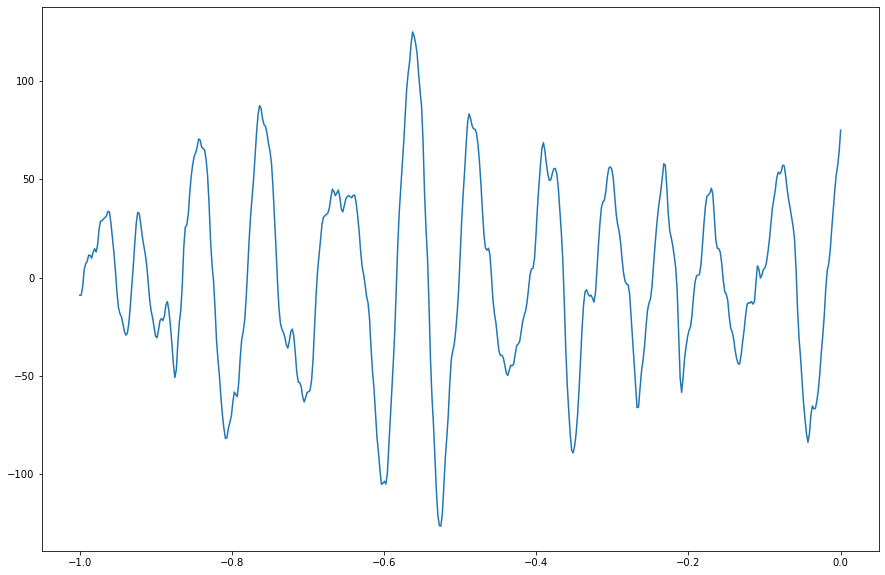

In [31]:
filtered_data = epochs_filtered.get_data()
time_index = np.where((epochs_filtered.times <= 0) & (epochs_filtered.times >= -1))
time_series = np.squeeze(filtered_data[99,:, time_index])

plt.plot(example_channel.times[time_index],time_series)

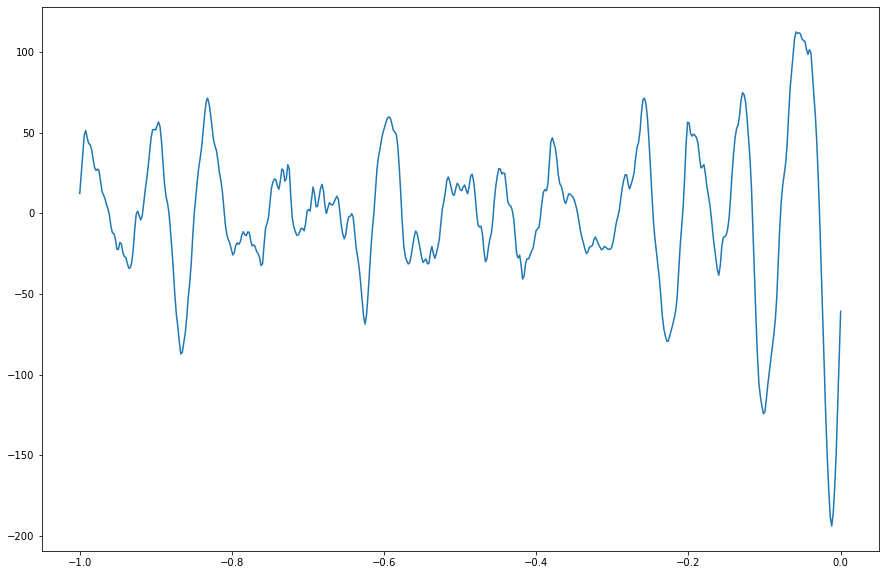

In [32]:
filtered_data = epochs_filtered.get_data()
time_index = np.where((epochs_filtered.times <= 0) & (epochs_filtered.times >= -1))
time_series = np.squeeze(filtered_data[103,:, time_index])

plt.plot(example_channel.times[time_index],time_series)

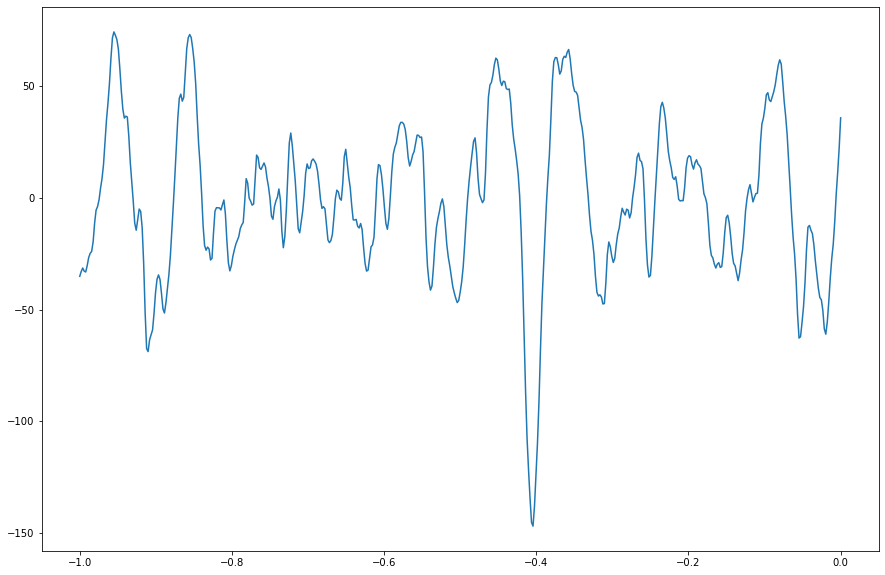

In [33]:
filtered_data = epochs_filtered.get_data()
time_index = np.where((epochs_filtered.times <= 0) & (epochs_filtered.times >= -1))
time_series = np.squeeze(filtered_data[42,:, time_index])

plt.plot(example_channel.times[time_index],time_series)

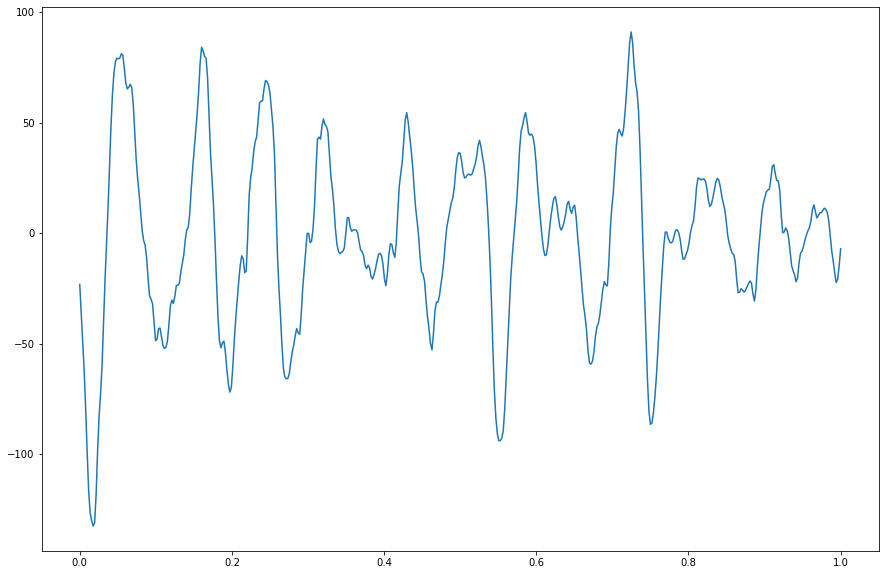

In [35]:
filtered_data = epochs_filtered.get_data()
time_index = np.where((epochs_filtered.times <= 1) & (epochs_filtered.times >= 0))
time_series = np.squeeze(filtered_data[88,:, time_index])

plt.plot(example_channel.times[time_index],time_series)

Setting up band-pass filter from 3 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 37.50 Hz (-6 dB cutoff frequency: 168.75 Hz)
- Filter length: 845 samples (1.650 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s


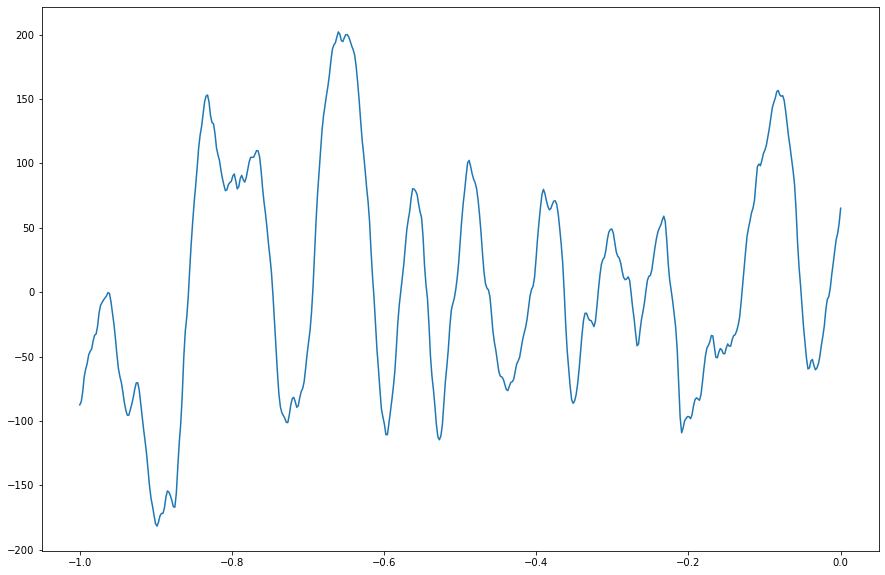

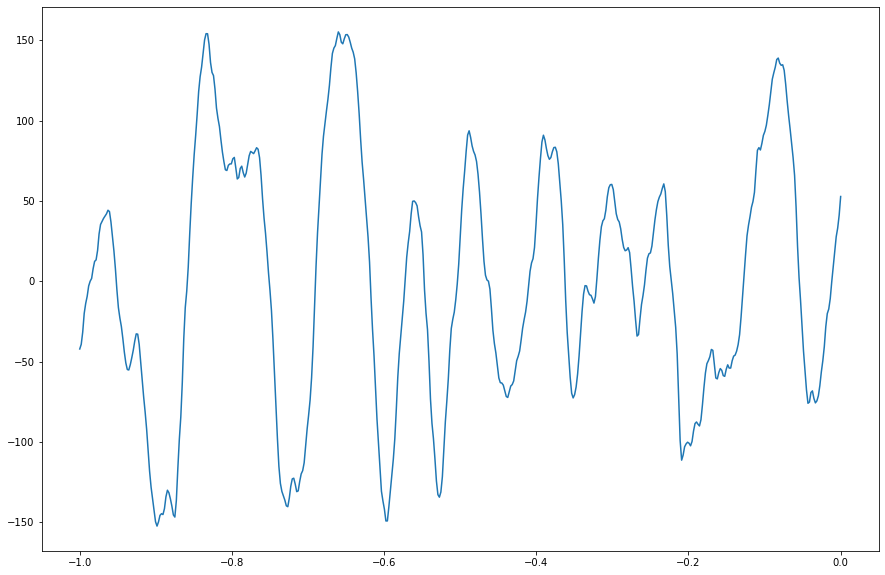

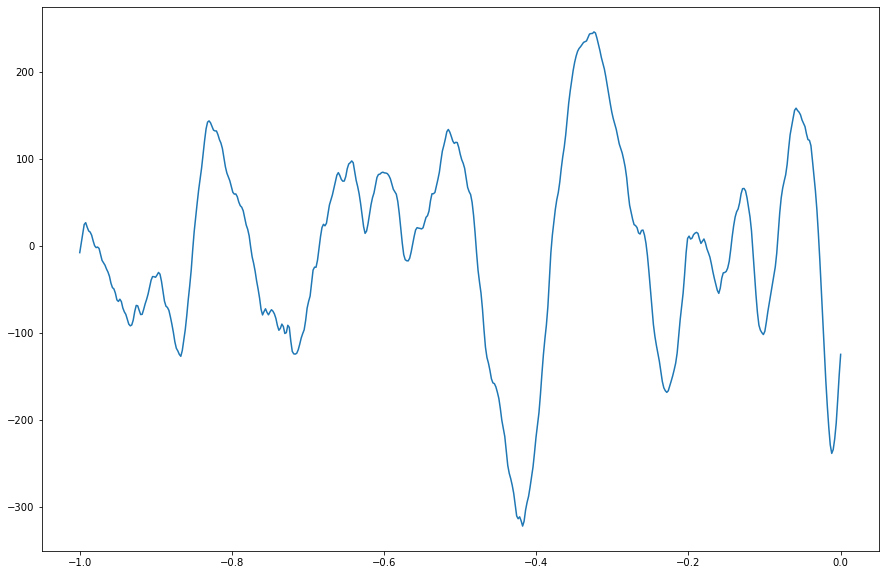

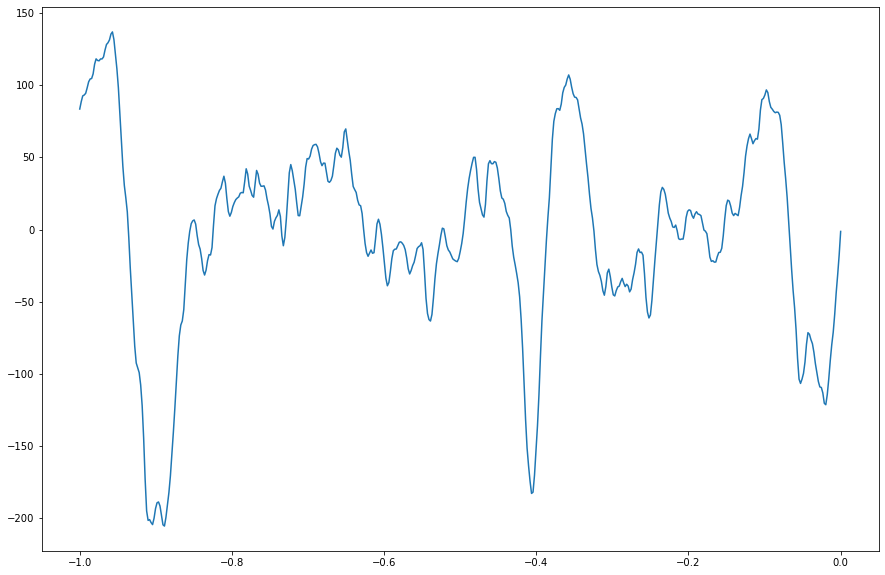

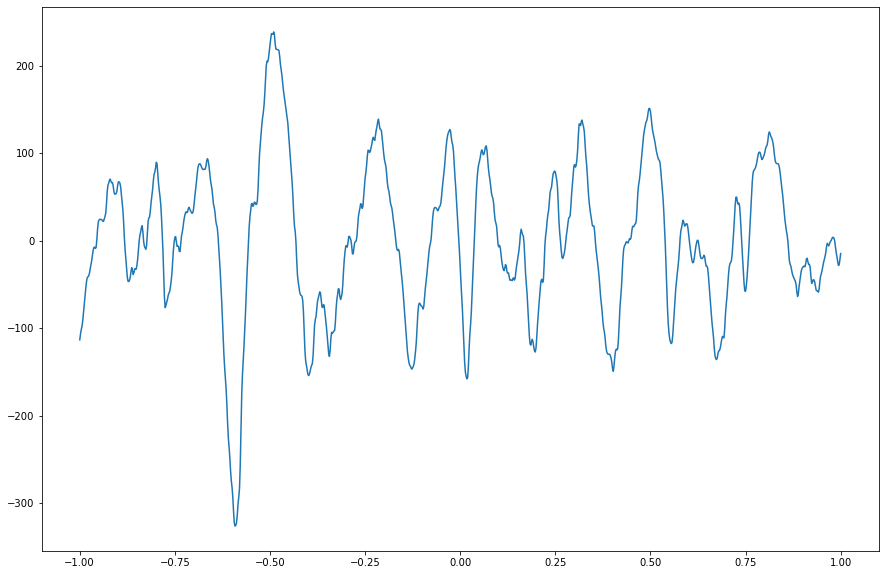